# Load data

In [2]:
import numpy as np
import xgboost
import pandas as pd

df = pd.read_csv("dataset/train.csv")
df_valid = pd.read_csv("dataset/validation.csv")
df_test = pd.read_csv("dataset/test.csv")

## Create Train Set

In [3]:
train_split = np.array_split(df, 1)
train = train_split[0]
train_y = train['click']

cols = ['click', 'weekday', 'hour', 'bidid', 'logtype', 'userid', 'useragent',
       'IP', 'region', 'city', 'adexchange', 'domain', 'url', 'urlid',
       'slotid', 'slotwidth', 'slotheight', 'slotvisibility', 'slotformat',
       'slotprice', 'creative', 'payprice', 'keypage',
       'advertiser', 'usertag', 'bidprice']

train_x = train[cols]

## Feature Extraction

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import re

label_encoder = LabelEncoder()
vectorizer = DictVectorizer()

def get_browser(useragent):
    useragent_data = re.split('_',useragent)
    return useragent_data[1]

def get_os(useragent):
    useragent_data = re.split('_',useragent)
    return useragent_data[0]

def bid_request_features(bid,have_click):
    result = defaultdict(float)
    result['weekday=' + str(bid['weekday'].item())] += 1.0
    result['hour=' + str(bid['hour'].item())] += 1.0
    result['userid=' + bid['userid']] += 1.0
    result['broswer=' + get_browser(bid['useragent'])] += 1.0
    result['os=' + get_os(bid['useragent'])] += 1.0
    result['IP=' + bid['IP']] += 1.0
    result['region=' + str(bid['region'].item())] += 1.0
    result['city=' + str(bid['city'].item())] += 1.0
    result['adexchange=' + bid['adexchange']] += 1.0
    result['domain=' + bid['domain']] += 1.0
    result['url=' + bid['url']] += 1.0
    result['slotid=' + bid['slotid']] += 1.0
    result['slotwidth=' + str(bid['slotwidth'].item())] += 1.0
    result['slotheight=' + str(bid['slotheight'].item())] += 1.0
    result['slotvisibility=' + bid['slotvisibility']] += 1.0
    result['slotformat=' + bid['slotformat']] += 1.0
    result['slotprice=' + str(bid['slotprice'].item())] += 1.0
    result['creative=' + bid['creative']] += 1.0
    result['keypage=' + bid['keypage']] += 1.0 
    result['advertiser=' + str(bid['advertiser'].item())] += 1.0

    usertag_data = re.split(',',bid['usertag'])
    for tag in usertag_data:
        result['usertag=' + str(tag)] += 1.0
        
    if have_click == 1:
        result['click=' + str(bid['click'].item())] += 1.0
        
    return result

In [4]:
bid_request_features(train_x.iloc[0],0)

defaultdict(float,
            {'IP=180.107.112.*': 1.0,
             'adexchange=2': 1.0,
             'advertiser=1458': 1.0,
             'broswer=ie': 1.0,
             'city=85': 1.0,
             'creative=612599432d200b093719dd1f372f7a30': 1.0,
             'domain=trqRTuToMTNUjM9r5rMi': 1.0,
             'hour=14': 1.0,
             'keypage=bebefa5efe83beee17a3d245e7c5085b': 1.0,
             'os=windows': 1.0,
             'region=80': 1.0,
             'slotformat=0': 1.0,
             'slotheight=60': 1.0,
             'slotid=433287550': 1.0,
             'slotprice=5': 1.0,
             'slotvisibility=1': 1.0,
             'slotwidth=468': 1.0,
             'url=d48a96ab59d7ad741a48e781de44efeb': 1.0,
             'userid=u_Vh1OPkFv3q5CFdR': 1.0,
             'usertag=10063': 1.0,
             'usertag=13866': 1.0,
             'weekday=1': 1.0})

In [113]:
vectorizer.transform(bid_request_features(train_x.iloc[0],0)) 

<1x4021134 sparse matrix of type '<class 'numpy.float64'>'
	with 22 stored elements in Compressed Sparse Row format>

In [5]:
train_bid_x = vectorizer.fit_transform([bid_request_features(train_x.iloc[i],0) for i in range(len(train_x))])
train_bid_y = label_encoder.fit_transform([train_x.iloc[i]['click'] for i in range(len(train_x))])    

In [6]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

# model = xgboost.XGBClassifier()
# model.fit(train_bid_x, train_bid_y)

model = LogisticRegression(C=1.3, penalty='l1', solver='liblinear', class_weight = 'balanced', verbose = 1)
model = model.fit(train_bid_x, train_bid_y)

# model = GradientBoostingClassifier()
# model = model.fit(train_bid_x, train_bid_y)

# model = AdaBoostClassifier()
# model = model.fit(train_bid_x, train_bid_y)

[LibLinear]

In [ ]:
model_isotonic = CalibratedClassifierCV(model, cv=2, method='isotonic')
model_isotonic.fit(train_bid_x2, train_bid_y2)

## Click Probability Prediction

In [9]:
bid_y= []

def predict_click_probab(test_bids):
    bid_x = vectorizer.transform([bid_request_features(test_bids.iloc[i],0) for i in range(len(test_bids))])
    bid_y.append(model.predict_proba(bid_x))
    return bid_y

### Experimenting with PCA and SVD and Feature Selection

In [43]:
from sklearn.decomposition import PCA, TruncatedSVD

bid_y = []
bid_x = vectorizer.transform([bid_request_features(valid_x.iloc[0],0)])
svd = TruncatedSVD(n_iter=7, algorithm='arpack')
bid_x_t = bid_x.transpose()
bid_x[0].shape

(1, 4021134)

In [47]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(model, threshold=0.25)
sfm.fit(train_bid_x, train_bid_y)

In [59]:
def sfm_transform(bid):
    return sfm.transform(bid)[0]

In [52]:
trf[0]

<1x3 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [ ]:
bid_y_iso= []

def predict_click_probab(test_bids):
    bid_x = vectorizer.transform([bid_request_features(test_bids.iloc[i],0) for i in range(len(test_bids))])
    bid_y_iso.append(model_isotonic.predict_proba(bid_x))
    return bid_y_iso

# Random Bidding Strategy

In [6]:
valid_x['bid_pred_rnd'].mean()

254.52222025761554

- Get random bid price
- Assess if you'd win - if your score is bigger than the current bid
- If it is, you win it and you deduct cost

In [7]:
len(valid_x['bid_pred_rnd'])

299749

In [106]:
import random
from collections import defaultdict

upper_limits = range(450,550,1)
click_log = []
impr_log = []

def generate_random_bid(upper_limit):
    bids = []
    for i in range(0,len(valid_x)):
        bid = random.randrange(0,upper_limit,1)
        bids.append(bid) 
    valid_x['bid_pred_rnd'] = bids   
    
valid_x['bidprice'] = valid['bidprice']
valid_x['payprice'] = valid['payprice']
valid_x['click'] = valid['click']

def bidding_strategy(limit):
    budget = 6250
    clicks = 0
    impressions = 0
    for i in range(0,len(valid_x)):
        if budget > 0 or i!=len(valid_x): 
            if valid_x['bid_pred_rnd'][i] > valid_x['bidprice'][i]:
                clicks += valid_x['click'][i]
                impressions += 1 
                budget -= valid_x['payprice'][i]/1000
        else:
            break
    
    click_log.append(clicks)
    impr_log.append(impressions)


for limit in upper_limits:
    generate_random_bid(limit)
    bidding_strategy(limit)

In [110]:
CTR = [(a/b)*100 for a,b in zip(click_log,impr_log)]
eCPC = [(6250/a) for a in click_log]
CPM = [(6250/a)*1000 for a in impr_log]

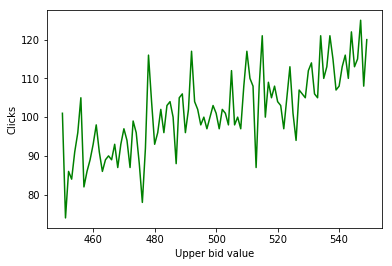

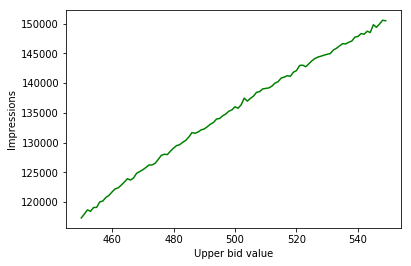

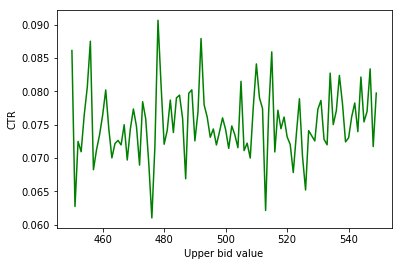

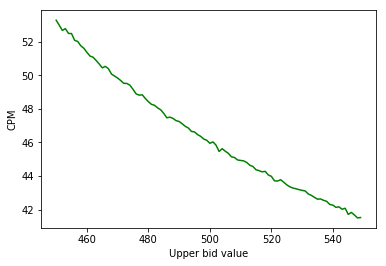

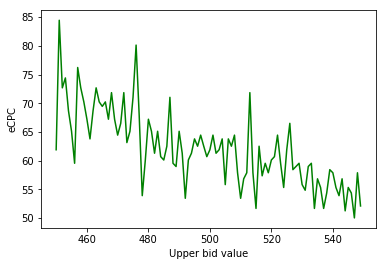

In [109]:
import matplotlib.pyplot as plt


plt.plot(upper_limits, click_log, 'g')
plt.ylabel('Clicks')
plt.xlabel('Upper bid value')
plt.show()

plt.plot(upper_limits, impr_log, 'g')
plt.ylabel('Impressions')
plt.xlabel('Upper bid value')
plt.show()

plt.plot(upper_limits, CTR, 'g')
plt.ylabel('CTR')
plt.xlabel('Upper bid value')
plt.show()

plt.plot(upper_limits, CPM, 'g')
plt.ylabel('CPM')
plt.xlabel('Upper bid value')
plt.show()

plt.plot(upper_limits, eCPC, 'g')
plt.ylabel('eCPC')
plt.xlabel('Upper bid value')
plt.show()

## Test click prediction on validation set

Test if the clicks predicted by the LR model align with the data in the validation set and minimise the difference.

In [10]:
valid_cols = ['weekday', 'bidid', 'hour', 'userid', 'useragent',
       'IP', 'region', 'city', 'adexchange', 'domain', 'url', 'urlid',
       'slotid', 'slotwidth', 'slotheight', 'slotvisibility', 'slotformat',
       'slotprice', 'creative', 'keypage',
       'advertiser', 'usertag']

valid_split = np.array_split(df_valid, 1)
valid = valid_split[0]
valid_x = valid[valid_cols]

Examples of validation set entries

In [11]:
valid_x[:3]

,weekday,bidid,hour,userid,useragent,IP,region,city,adexchange,domain,...,slotid,slotwidth,slotheight,slotvisibility,slotformat,slotprice,creative,keypage,advertiser,usertag
0,5,91c6a6b9e90c0f54d3230815a5a3e22e,14,u_Vhk7C5STO8TZ3s8,windows_ie,14.122.240.*,216,232,1,trqRTJ27Pea7gspy,...,mm_34061467_3440569_11228047,300,250,0,1,0,449a22cd91d9042eda3d3a1b89a22ea8,0f951a030abdaedd733ee8d114ce2944,3427,"10006,10063,10059,10111"
1,3,24b3621ad3b063b6c09c541781d534b3,14,u_DANDbCAksMy,android_safari,116.22.55.*,216,217,null,null,...,1,320,50,FirstView,Na,118,11908,null,2997,null
2,1,6e7bce0a9ad42f479827d37bf9618a9d,13,u_VhkxPnKHPo1H3Vb,windows_ie,60.215.242.*,146,149,3,3FKElpuEMusyJqKbuKz,...,ALLINONE_F_Width1,1000,90,0,0,70,d01411218cc79bc49d2a4078c4093b76,b2e35064f3549d447edbbdfb1f707c8c,3427,null


Predict click probabilities on validation set

In [12]:
click_valid_guess = predict_click_probab(valid_x)

In [14]:
click_valid_guess

[array([[  9.99681537e-01,   3.18462549e-04],
        [  9.92684918e-01,   7.31508237e-03],
        [  9.96831326e-01,   3.16867437e-03],
        ..., 
        [  9.98477931e-01,   1.52206878e-03],
        [  9.99696253e-01,   3.03747266e-04],
        [  9.99462299e-01,   5.37701457e-04]])]

Count number of entries with click probability higher than 50%:

In [96]:
count = 0
for click in click_valid_guess[0]:
    if click[1]>=0.5:
        count += 1

print(count)

46


# Export data to CSV

Export to CSV file predicted click

In [18]:
import csv

valid_x['bidid'] = valid['bidid']
valid_x['pred_click'] = click_valid_guess

with open("out.csv", "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for i in range(0,len(valid_x)):
        writer.writerow([valid_x['bidid'][i], valid_x['pred_click'][i]])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Export to CSV file predicted click probabilities on validation set

In [160]:
import csv

valid_x['bidid'] = valid['bidid']
valid_x['pred_click'] = click_valid_guess[0].tolist()

with open("click_pred_l1reg.csv", "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for i in range(0,len(valid_x)):
        writer.writerow([valid_x['bidid'][i], valid_x['pred_click'][i][0], valid_x['pred_click'][i][1]])

Export to CSV file predicted click probabilities on test set

In [24]:
import csv

test_x['bidid'] = test['bidid']
test_x['pred_click'] = click_test_guess[1].tolist()

with open("click_pred_l1reg_test.csv", "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for i in range(0,len(test_x)):
        writer.writerow([test_x['bidid'][i], test_x['pred_click'][i][0], test_x['pred_click'][i][1]])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Export to CSV predicted optimal bid on validation set

In [136]:
import csv

valid_x['bidid'] = valid['bidid']
valid_x['optimal_bid'] = o_bids

with open("optimal_bids_5apr.csv", "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for i in range(0,len(valid_x)):
        writer.writerow([valid_x['bidid'][i], valid_x['optimal_bid'][i]])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Export to CSV predicted optimal bid on test set

In [160]:
import csv

test_x['bidid'] = test['bidid']
test_x['optimal_bid'] = o_bids

with open("optimal_bids_test.csv", "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerow(['bidid', 'bidprice'])
    for i in range(0,len(test_x)):
        writer.writerow([test_x['bidid'][i], test_x['optimal_bid'][i]])

Calculate pCTR on validation set with click predictions:

# Exploration on Validation Set

True value of clicks in validation set:

In [14]:
valid_x['click'].sum()

226

Example of validation set entry:

In [21]:
valid_x.iloc[0]

weekday                                          5
hour                                            14
userid                           u_Vhk7C5STO8TZ3s8
useragent                               windows_ie
IP                                    14.122.240.*
region                                         216
city                                           232
adexchange                                       1
domain                            trqRTJ27Pea7gspy
url               b3f4c620ae8d3df230fca2fbed50d247
urlid                                         null
slotid                mm_34061467_3440569_11228047
slotwidth                                      300
slotheight                                     250
slotvisibility                                   0
slotformat                                       1
slotprice                                        0
creative          449a22cd91d9042eda3d3a1b89a22ea8
keypage           0f951a030abdaedd733ee8d114ce2944
advertiser                     

## Predict Click Probability on Test Set

In [16]:
test_cols = ['weekday', 'bidid', 'hour', 'userid', 'useragent',
       'IP', 'region', 'city', 'adexchange', 'domain', 'url', 'urlid',
       'slotid', 'slotwidth', 'slotheight', 'slotvisibility', 'slotformat',
       'slotprice', 'creative', 'keypage',
       'advertiser', 'usertag']

test_split = np.array_split(df_test, 1)
test = test_split[0]
test_x = test[test_cols]

In [17]:
click_test_guess = predict_click_probab(test_x)

In [21]:
click_test_guess

[array([[  9.99681537e-01,   3.18462549e-04],
        [  9.92684918e-01,   7.31508237e-03],
        [  9.96831326e-01,   3.16867437e-03],
        ..., 
        [  9.98477931e-01,   1.52206878e-03],
        [  9.99696253e-01,   3.03747266e-04],
        [  9.99462299e-01,   5.37701457e-04]]),
 array([[  9.99605424e-01,   3.94576015e-04],
        [  9.99096868e-01,   9.03131978e-04],
        [  9.99873002e-01,   1.26998001e-04],
        ..., 
        [  9.98309968e-01,   1.69003185e-03],
        [  9.99987287e-01,   1.27132162e-05],
        [  9.99925188e-01,   7.48124906e-05]])]

In [23]:
count = 0
for click in click_test_guess[1]:
    if click[1]>=0.5:
        count += 1
print(count)

49


## *Predict Payprice for Test Set

In [10]:
train_payprice_x = vectorizer.fit_transform([bid_request_features(train_x.iloc[i],1) for i in range(len(train_x))])
train_payprice_y = label_encoder.fit_transform([train_x.iloc[i]['payprice'] for i in range(len(train_x))])  

In [ ]:
from sklearn.linear_model import LinearRegression

model_pp = LinearRegression()
model_pp = model_pp.fit(train_payprice_x, train_payprice_y)

[LibLinear]

Steps for cross-validation:
- run prediction on the validation set
- calculate which C value causes the lowest error
- use optimal C for prediction on test set

In [ ]:
payprice_test_guess = predict_payprice(valid_x)
abs_diff = abs(payprice_test_guess - valid_x['payprice'])
abs_diff.mean()

# ORTB1 Predict

ORTB Bidding Function 1 on <b>validation</b> set:

In [41]:
import math

c_values = [20,50,80]

def predict_optimal_bid(click_probab,c):
    a = 5.2*(10**(-7))
    bid = math.sqrt((c/a)*click_probab + c**2) - c
    return bid

o_bids_valid = []
count = 0
cvg = np.asarray(click_valid_guess)

for i in range(0,len(cvg[0])):
    click_probab = cvg[0][i][1]
    for c in c_values:
        bid = predict_optimal_bid(click_probab,c)
        o_bids_valid.append(bid)[0]

In [129]:
import math

c=53
bids_forc = defaultdict()

def predict_optimal_bid(click_probab,c):
    a = 5.2*(10**(-7))
    bid = math.sqrt((c/a)*click_probab + c**2) - c
    return bid

cvg = np.asarray(click_valid_guess)

def predict_bid(c):
    o_bids_valid = []
    for i in range(0,len(cvg[0])):
        click_probab = cvg[0][i][1]
        bid = predict_optimal_bid(click_probab,c)
        o_bids_valid.append(bid)
    return o_bids_valid
        
for c in c_values:
    bids_forc[c] = predict_bid(c)

In [155]:
sum(bids_forc[53])/len(bids_forc[53])

192.30060010087723

In [87]:
optimal_bids_perc = [o_bids_valid[i:i + len(cvg[0])] for i in range(0, len(o_bids_valid), len(cvg[0]))] 

20

In [107]:
optimal_bids_perc[2][:5]

[515.025675948618,
 518.9954822112824,
 82.80818609938252,
 83.49858166800972,
 84.17425688971424]

In [46]:
c_20 = [o_bids_valid[i:i + len(cvg[0])] for i in range(0, len(o_bids_valid), len(cvg[0]))][0]
c_50 = [o_bids_valid[i:i + len(cvg[0])] for i in range(0, len(o_bids_valid), len(cvg[0]))][1]
c_80 = [o_bids_valid[i:i + len(cvg[0])] for i in range(0, len(o_bids_valid), len(cvg[0]))][2]

In [82]:
c20 = np.asarray(c_20)
count = 0
for i in range(0,len(c20)):
    if c20[i] < 500:
        count += 1.0
print(count)

281024.0


In [81]:
cp= []

for i in range(0,len(cvg[0])):
    click_probab = cvg[0][i][1]
    cp.append(click_probab)
    
len(cp)

299749

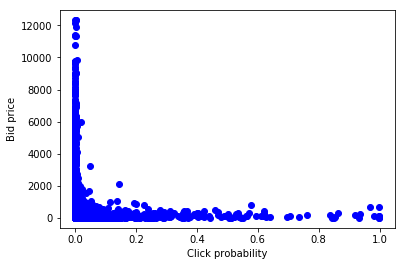

In [80]:
import matplotlib.pyplot as plt

plt.plot(cp, c_20, 'ob')
plt.ylabel('Bid price')
plt.xlabel('Click probability')
plt.show()

ORTB Bidding Function 1 on <b>test</b> set with optimal c=53:

In [156]:
import math

def predict_optimal_bid(click_probab):
    c = 53
    a = 5.2*(10**(-7))
    bid = math.sqrt((c/a)*click_probab + c**2) - c
    return bid

o_bids = []
count = 0
cvg = np.asarray(click_valid_guess)
ctg = np.asarray(click_test_guess)

for i in range(0,len(ctg[1])):
    click_probab = ctg[1][i][1]
    bid = predict_optimal_bid(click_probab)
    o_bids.append(bid)

In [157]:
o_bids[:10]

[154.42565298317032,
 254.99186680588707,
 72.51106320953055,
 173.58287224491858,
 1.9035082503997103,
 101.92933889300625,
 129.2414188038134,
 1.8768687730390994,
 179.80575242306918,
 125.10507755411453]

## *Predict bid price for Test Set

Make a prediction on the bid price, given the click information data added to the test set. It should know what bid is good, depending on the advertiser and the historical bidding.

In [161]:
import math

# test_x['click'] = click_test_guess

def predict_bidprice(test_bids):
    bid_x = vectorizer.transform([bid_request_features(test_bids.iloc[i],1) for i in range(len(test_bids))])
    bid_y = model_b.predict(bid_x)
    return bid_y

In [16]:
# bid2_x = vectorizer.transform([bid_request_features(valid_x.iloc[i],1) for i in range(len(valid_x))])
# bid2_y = label_encoder.inverse_transform(np.array(math.ceil(model_b.predict(bid2_x)[0])))

# # bid_y = label_encoder.inverse_transform(model_b.predict(bid_x))
# # len(bid_request_features(valid_x.iloc[0],1))
# # vectorizer.transform([bid_request_features(valid_x.iloc[140],1)]).sum()
# # bid_request_features(valid_x.iloc[0],1)
# # model_b.predict(vectorizer.transform([bid_request_features(valid_x.iloc[0],1)]))
# # model_b.predict(bid_x)[0]

# bid_request_features(valid_x.iloc[0],1)


In [162]:
train_bid_x = vectorizer.fit_transform([bid_request_features(train_x.iloc[i],1) for i in range(math.ceil(len(train_x)/4))])
train_bid_y = [train_x.iloc[i]['bidprice'] for i in range(math.ceil(len(train_x)/4))]

In [163]:
# from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# model_b = LinearRegression()
# model_b = model_b.fit(train_bid_x, train_bid_y)

model_b = Ridge(alpha=0.8)
model_b = model_b.fit(train_bid_x, train_bid_y)

In [165]:
# bidprice_test_guess = predict_bidprice(test_x)
valid_x['click'] = valid['click']
bidprice_valid_guess = predict_bidprice(valid_x)
valid_x['bidprice'] = valid['bidprice']
abs_diff = abs(bidprice_valid_guess - valid_x['bidprice'])
abs_diff.mean()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.83292797626960868

In [167]:
valid_x['bid_pred'] = bidprice_valid_guess
valid_x['diff'] = abs(valid_x['bid_pred'] - valid_x['bidprice'])

In [168]:
valid_x['bid_pred'].mean()

272.40980105015979

# E

In [130]:
valid_x['payprice'] = valid['payprice']
valid_x['bidprice'] = valid['bidprice']
valid_x['click'] = valid['click']
click_dict = defaultdict()

def evaluate_bids(o_bids,c):
    budget = 6250
    clicks = 0
    impressions = 0

    for i in range(0,len(valid_x)):
        if (o_bids[i] > valid_x['bidprice'][i]):
            clicks += valid_x['click'][i]
            impressions += 1
            if budget > 0:    
                budget -= valid_x['payprice'][i]/1000
            else:
                print('Budget over')
                break

    click_dict[c] = clicks
    print("Clicks: " + str(clicks))
    print("Impressions: " + str(impressions))
    print("CTR:" + str((clicks/impressions) * 100))
    print("Bids considered: " + str(i) + "/" + str(len(valid_x)))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [90]:
len(optimal_bids_perc[0])

299749

In [131]:
for c in c_values:
    bid_values = bids_forc[c]
    print("Value of c: " + str(c))
    evaluate_bids(bid_values,c)
    

Value of c: 10
Clicks: 118
Impressions: 14825
CTR:0.795952782462
Bids considered: 299748/299749
Value of c: 11
Clicks: 120
Impressions: 16488
CTR:0.727802037846
Bids considered: 299748/299749
Value of c: 12
Clicks: 125
Impressions: 18034
CTR:0.693135189087
Bids considered: 299748/299749
Value of c: 13
Clicks: 128
Impressions: 19629
CTR:0.652096387997
Bids considered: 299748/299749
Value of c: 14
Clicks: 133
Impressions: 21193
CTR:0.627565705658
Bids considered: 299748/299749
Value of c: 15
Clicks: 134
Impressions: 22661
CTR:0.591324301664
Bids considered: 299748/299749
Value of c: 16
Clicks: 134
Impressions: 24155
CTR:0.55475056924
Bids considered: 299748/299749
Value of c: 17
Clicks: 135
Impressions: 25521
CTR:0.528976137299
Bids considered: 299748/299749
Value of c: 18
Clicks: 137
Impressions: 26916
CTR:0.50899093476
Bids considered: 299748/299749
Value of c: 19
Clicks: 137
Impressions: 28297
CTR:0.484150263279
Bids considered: 299748/299749
Value of c: 20
Clicks: 137
Impressions: 29

In [145]:
budget_spent = 6250
CPC = budget_spent/clicks
CPC

39.808917197452232

In [158]:
click_dict.values()

dict_values([118, 120, 125, 128, 133, 134, 134, 135, 137, 137, 137, 139, 141, 142, 143, 144, 145, 146, 146, 147, 147, 149, 150, 150, 152, 152, 153, 153, 154, 155, 155, 155, 156, 157, 157, 157, 157, 157, 157, 157, 157, 158, 158, 158, 155, 153, 151, 150, 149, 147, 144, 143, 143, 141, 139, 135, 134, 133, 134, 133, 132, 130, 130, 130, 130, 129, 129, 129, 129, 129, 127, 128, 128, 126, 126, 126, 126, 126, 126, 126])

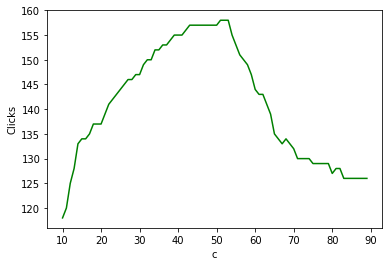

In [153]:
import matplotlib.pyplot as plt

plt.plot(c_values, list(click_dict.values()), 'g')
plt.ylabel('Clicks')
plt.xlabel('c')
plt.show()

In [146]:
obids = np.asarray(o_bids)
np.mean(obids)

187.69615625381013

In [147]:
CPM = (budget_spent/impressions) *1000
CPM

99.43995417806912

## Predict chance of winning

Use winning function from ORTB paper to determine chance of winning.

In [36]:
win = 0
count = 0
for bid in valid_x['bid_pred']:
    if bid >= valid_x['bidprice'][count]:
        win += 1
    count += 1
    
print(win/len(valid_x['bid_pred']))

0.4949874728522864


In [56]:
win = 0

for bid in valid_x['bid_pred']:
    w = bid / (bid+80)
    if w > 0.75:
        win += 1
    
print(win)
print(win/len(valid_x['bid_pred']))

231865
0.7735305205355147


In [58]:
def predict_optimal_bid(click_pred):
    c = 80
    a = 5.2*(10**(-7))
    bid = math.sqrt((c/a)*click_pred + c**2) - c
    return bid

In [182]:
bids = []
for i in range(0,len(valid_x)):
    bid = predict_optimal_bid(valid_x['pred_click'][i])
    bids.append(bid)
bids[:10]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]